# Reading from database and prepare target feature

In [1]:
#jupyter url: http://127.0.0.1:8888/tree?token=c5e7b85d8d8ce509ff8fb04aab3b69df33e8bfbb13a10287

In [1]:
%cd /home/luzinsan/Documents/Obsidian/ML/Innopolis/material/1 semester/Machine Learning/Project/notebooks
!ls

/home/luzinsan/Documents/Obsidian/ML/Innopolis/material/1 semester/Machine Learning/Project/notebooks
data-profiling.ipynb  orders.ipynb


/home/luzinsan/.cache/pypoetry/virtualenvs/ml-venv-uqlfkjfM-py3.11/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
import pandas as pd
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

session_engine = create_engine('sqlite:///../F24.ML.Assignment.One.data.db')

with session_engine.connect() as conn: 
    orders = pd.read_sql_query(text('SELECT * FROM joined_table'), con=conn) 
    
orders.to_csv('../content/full_orders_df.csv', index=False)
orders

,store_id,order_id,products,order_price,profit,delivery_distance,date_create,order_start_prepare,planned_prep_time,order_ready,order_pickup,region_id,status_id
0,5014,20562761,2,56.880,45.504,2205,2024-09-05 15:25:25,2024-09-05 15:25:33,15.0,2024-09-05 15:32:00,05-09-2024 16:00:00,683,F
1,3856,20562753,2,60.672,30.336,1368,2024-09-05 15:25:12,2024-09-05 15:25:19,10.0,2024-09-05 15:35:50,05-09-2024 16:03:50,683,F
2,10825,20562723,1,54.510,43.608000000000004,459,2024-09-05 15:23:32,2024-09-05 15:23:44,20.0,2024-09-05 15:38:38,05-09-2024 16:06:38,683,F
3,5640,20562673,2,41.080,32.864,2611,2024-09-05 15:19,2024-09-05 15:19:05,20.0,2024-09-05 15:35:25,05-09-2024 16:03:25,709,F
4,7283,20562665,1,22.120,11.06,1041,2024-09-05 15:18:39,None,15.0,2024-09-05 15:35:33,05-09-2024 16:03:33,707,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
517605,9007,18671231,3,153.418,122.73440000000001,5411,2024-05-08 00:02:22,2024-05-08 00:02:37,25.0,2024-05-08 00:36:25,08-05-2024 01:04:25,707,F
517606,8929,18671229,4,80.580,40.29,5499,2024-05-08 00:02:59,2024-05-08 00:10:07,30.0,2024-05-08 00:22:04,08-05-2024 00:50:04,683,F
517607,8721,18671227,1,30.020,6.0040000000000004,4396,2024-05-08 00:01:38,2024-05-08 00:01:50,20.0,2024-05-08 00:49:19,08-05-2024 01:17:19,691,F
517608,5863,18671225,1,31.600,15.8,560,2024-05-08 00:01:46,2024-05-08 00:02:01,15.0,2024-05-08 00:10:29,08-05-2024 00:38:29,703,F


In [11]:
date_cols = ['date_create', 'order_start_prepare', 'order_ready'] 
for col_name in date_cols:
    orders[col_name] = pd.to_datetime(orders[col_name], format='mixed')

orders['order_pickup'] = pd.to_datetime(orders['order_pickup'], dayfirst=True)

In [14]:
def impute_dates_by_store(x):
    diff_date = x['order_start_prepare'] - x['date_create']
    mean_diff = diff_date[diff_date > pd.to_timedelta("0 days")].mean()
    x.loc[x['order_start_prepare'].isnull(), 'order_start_prepare'] = x.loc[x['order_start_prepare'].isnull(), 'date_create'] + mean_diff
    x.loc[x['date_create'].isnull(), 'date_create'] = x.loc[x['date_create'].isnull(), 'order_start_prepare'] - mean_diff
    return x

orders.loc[:,['order_start_prepare','date_create']] = orders.groupby("store_id")\
        .apply(lambda x: impute_dates_by_store(x))\
        .reset_index(allow_duplicates=True)\
        .set_index('level_1')[['order_start_prepare', 'date_create']]


In [37]:
print("Observations with None in 'date_create' and 'order_start_prepare': ", (orders['date_create'].isnull() \
                                                                              & orders['order_start_prepare'].isnull()).sum(), 
      "\nWill be drop in the next line")
orders = orders[~(orders['date_create'].isnull() & orders['order_start_prepare'].isnull())]
orders.shape

Observations with None in 'date_create' and 'order_start_prepare':  28 
Will be drop in the next line


(517582, 13)

In [38]:
nan_indexes = orders[orders['date_create'].isnull()].index
orders[orders['date_create'].isnull()]

,store_id,order_id,products,order_price,profit,delivery_distance,date_create,order_start_prepare,planned_prep_time,order_ready,order_pickup,region_id,status_id


In [41]:
orders[orders['order_ready'].isnull()]

,store_id,order_id,products,order_price,profit,delivery_distance,date_create,order_start_prepare,planned_prep_time,order_ready,order_pickup,region_id,status_id
26,9559,20562475,5,126.005,25.201,1367,2024-09-05 15:02:42,2024-09-05 15:02:53.000000000,15.0,NaT,2024-09-05 15:41:31,717,F
28,3610,20562469,1,34.760,17.38,2548,2024-09-05 15:02:46,2024-09-05 15:02:50.000000000,20.0,NaT,2024-09-05 15:32:17,689,F
29,4894,20562467,3,185.255,37.051,129,2024-09-05 15:02:19,2024-09-05 15:02:28.000000000,30.0,NaT,2024-09-05 15:53:38,683,F
30,5355,20562455,2,142.990,71.495,1667,2024-09-05 15:08:23,2024-09-05 15:08:38.000000000,35.0,NaT,2024-09-05 16:00:11,691,F
38,3149,20562415,3,52.456,41.9885,2974,2024-09-05 14:58:58,2024-09-05 14:59:10.000000000,25.0,NaT,2024-09-05 15:59:47,685,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
517542,8939,18671487,5,136.670,None,3302,2024-05-08 00:36:55,2024-05-08 00:37:04.000000000,35.0,NaT,2024-05-08 01:24:06,683,F
517543,4757,18671481,1,15.405,None,2070,2024-05-08 00:36:04,2024-05-08 00:39:10.000000000,20.0,NaT,2024-05-08 01:22:28,707,F
517562,6421,18671401,3,75.366,15.0732,996,2024-05-08 00:22:00,2024-05-08 00:22:06.000000000,25.0,NaT,2024-05-08 01:20:05,707,F
517565,9109,18671393,4,62.410,31.205,10479,2024-05-08 00:20:52,2024-05-08 00:20:58.000000000,40.0,NaT,2024-05-08 01:24:40,683,F


In [28]:
null_datecreate_mask = orders['date_create'].isnull()
orders.loc[null_datecreate_mask, 'date_create'] = orders.loc[null_datecreate_mask, 'order_start_prepare'] - pd.to_timedelta("10 s")
orders.loc[null_datecreate_mask]

,store_id,order_id,profit,delivery_distance,date_create,order_start_prepare,planned_prep_time,order_ready,order_pickup,region_id,status_id
1545,8367,20557147,17.696,4893,2024-09-05 01:35:28,2024-09-05 01:35:38,0.0,2024-09-05 01:49:44,05-09-2024 02:17:44,707,F
3171,6853,20551545,43.45,2643,2024-09-04 18:23:40,2024-09-04 18:23:50,15.0,2024-09-04 18:38:34,04-09-2024 19:06:34,709,F
4444,9383,20547365,15.168000000000001,4139,2024-09-04 13:03:45,2024-09-04 13:03:55,30.0,2024-09-04 13:27:11,04-09-2024 13:55:11,695,F
4769,4564,20546315,28.1635,4357,2024-09-04 12:47:55,2024-09-04 12:48:05,0.0,2024-09-04 12:24:47,04-09-2024 12:52:47,707,F
4843,5985,20546071,None,2814,2024-09-04 12:02:22,2024-09-04 12:02:32,0.0,2024-09-04 12:30:57,04-09-2024 12:58:57,707,F
...,...,...,...,...,...,...,...,...,...,...,...
504104,3056,18720905,24.103,10404,2024-05-11 02:01:40,2024-05-11 02:01:50,20.0,2024-05-11 02:18:17,11-05-2024 02:46:17,683,F
506463,9503,18712045,88.87499999999999,8846,2024-05-10 17:03:26,2024-05-10 17:03:36,15.0,2024-05-10 18:38:39,10-05-2024 19:06:39,683,F
511774,5763,18692611,75.84,4475,2024-05-09 14:11:26,2024-05-09 14:11:36,15.0,2024-05-09 14:24:58,09-05-2024 14:52:58,695,F
513433,6735,18686269,24.964000000000006,4607,2024-05-08 23:34:09,2024-05-08 23:34:19,15.0,2024-05-08 23:51:29,09-05-2024 00:19:29,689,F


In [30]:
null_orderstartprepare_mask = orders['order_start_prepare'].isnull()
orders.loc[null_orderstartprepare_mask, 'order_start_prepare'] = orders.loc[null_orderstartprepare_mask, 'date_create'] + pd.to_timedelta("10 s")
orders.loc[null_orderstartprepare_mask]

,store_id,order_id,profit,delivery_distance,date_create,order_start_prepare,planned_prep_time,order_ready,order_pickup,region_id,status_id
4,7283,20562665,11.06,1041,2024-09-05 15:18:39,2024-09-05 15:18:49,15.0,2024-09-05 15:35:33,05-09-2024 16:03:33,707,F
23,8941,20562501,28.044999999999998,3146,2024-09-05 15:05:04,2024-09-05 15:05:14,25.0,2024-09-05 15:27:16,05-09-2024 15:55:16,683,F
34,10523,20562435,17.6328,1507,2024-09-05 15:05:06,2024-09-05 15:05:16,20.0,2024-09-05 15:19:21,05-09-2024 15:47:21,717,F
57,8367,20562343,11.06,6071,2024-09-05 14:50:00,2024-09-05 14:50:10,20.0,2024-09-05 15:17:02,05-09-2024 15:45:02,707,F
65,5719,20562307,39.5,4388,2024-09-05 14:47:19,2024-09-05 14:47:29,30.0,2024-09-05 15:03:50,05-09-2024 15:31:50,683,F
...,...,...,...,...,...,...,...,...,...,...,...
517557,3871,18671423,13.113999999999999,2812,2024-05-08 00:25:26,2024-05-08 00:25:36,20.0,2024-05-08 00:42:50,08-05-2024 01:10:50,683,F
517563,3894,18671397,43.055,12309,2024-05-08 00:20:59,2024-05-08 00:21:09,25.0,2024-05-08 00:44:32,08-05-2024 01:12:32,695,F
517567,6841,18671385,22.515,3367,2024-05-08 00:20:00,2024-05-08 00:20:10,15.0,2024-05-08 00:35:06,08-05-2024 01:03:06,707,F
517573,4348,18671361,49.375,3252,2024-05-08 00:16:59,2024-05-08 00:17:09,25.0,None,08-05-2024 01:26:38,683,F


In [31]:
orders = orders[~orders['order_ready'].isnull()]
orders.shape

(466218, 11)

In [34]:
orders_with_target = orders.loc[~((orders['order_ready'] - orders['order_start_prepare']) < pd.to_timedelta('0 days'))]

In [35]:
orders_with_target.loc[:,'actual_prep_time'] = (orders_with_target['order_ready'] - orders_with_target['order_start_prepare']).dt.total_seconds() / 60

<Axes: ylabel='actual_prep_time'>

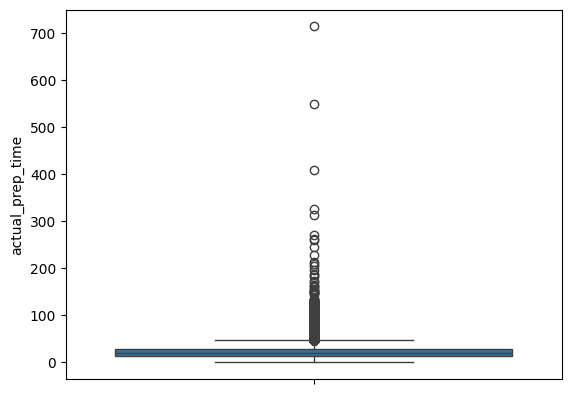

In [36]:
sns.boxplot(orders_with_target['actual_prep_time'])

In [37]:
orders_with_target.to_csv('../content/orders_with_target.csv', index=False)

# EDA

In [38]:
df = pd.read_csv('../content/orders_with_target.csv', parse_dates=['date_create', 'order_start_prepare', 'order_ready', 'order_pickup'])
df.sample(10)

,store_id,order_id,profit,delivery_distance,date_create,order_start_prepare,planned_prep_time,order_ready,order_pickup,region_id,status_id,actual_prep_time
199549,4742,19766127,90.060,9161,2024-07-16 15:59:10,2024-07-16 16:01:07,30.0,2024-07-16 16:14:55,2024-07-16 16:42:55,683,F,13.800000
108152,4679,20131565,14.220,251,2024-08-07 23:09:56,2024-08-07 23:10:06,20.0,2024-08-07 23:29:17,2024-07-08 23:57:17,703,F,19.183333
252682,3982,19548769,27.808,1702,2024-07-02 22:37:37,2024-07-02 22:37:42,15.0,2024-07-02 22:50:27,2024-02-07 23:18:27,707,F,12.750000
384700,9303,18998921,5.056,370,2024-05-28 14:34:13,2024-05-28 14:34:21,20.0,2024-05-28 14:44:16,2024-05-28 15:12:16,683,F,9.916667
28096,8517,20451361,30.810,4768,2024-08-28 19:49:01,2024-08-28 19:49:11,15.0,2024-08-28 20:03:02,2024-08-28 20:31:02,683,F,13.850000
114252,9315,20107085,45.504,948,2024-08-06 14:20:46,2024-08-06 14:21:01,20.0,2024-08-06 14:37:00,2024-06-08 15:05:00,707,F,15.983333
129022,3503,20047949,27.492,8022,2024-08-02 20:02:37,2024-08-02 20:02:47,25.0,2024-08-02 20:24:52,2024-02-08 20:52:52,683,F,22.083333
270385,6725,19477495,24.174,5452,2024-06-28 14:41:33,2024-06-28 14:42:22,25.0,2024-06-28 15:01:35,2024-06-28 15:29:35,683,F,19.216667
263632,3999,19504855,29.625,1013,2024-06-30 08:08:09,2024-06-30 08:08:15,25.0,2024-06-30 08:37:03,2024-06-30 09:05:03,707,F,28.800000
50602,3610,20362733,31.995,18867,2024-08-22 20:19:54,2024-08-22 20:20:04,20.0,2024-08-22 20:42:21,2024-08-22 21:10:21,689,F,22.283333


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464317 entries, 0 to 464316
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   store_id             464317 non-null  int64         
 1   order_id             464317 non-null  int64         
 2   profit               418127 non-null  float64       
 3   delivery_distance    464317 non-null  int64         
 4   date_create          464317 non-null  datetime64[ns]
 5   order_start_prepare  464317 non-null  datetime64[ns]
 6   planned_prep_time    464316 non-null  float64       
 7   order_ready          464317 non-null  datetime64[ns]
 8   order_pickup         464317 non-null  datetime64[ns]
 9   region_id            464317 non-null  int64         
 10  status_id            464317 non-null  object        
 11  actual_prep_time     464317 non-null  float64       
dtypes: datetime64[ns](4), float64(3), int64(4), object(1)
memory usage: 42.5